In [ ]:
!pip3 install torch torchvision opencv-python matplotlib

In [ ]:
import torch
import torchvision
from torchvision import transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Helper function to preprocess images
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((1080, 940)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    return transform(image).unsqueeze(0)

# Function to detect dominant color (white) within a bounding box
def is_white_shirt(box, frame):
    x1, y1, x2, y2 = box.int()
    cropped = frame[y1:y2, x1:x2]
    # Convert to HSV to detect white
    hsv_cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2HSV)
    
    # Define white color range in HSV
    lower_white = np.array([255, 255, 255], dtype=np.uint8)
    upper_white = np.array([215, 215, 215], dtype=np.uint8)
    
    # Create a mask to filter out white regions
    mask = cv2.inRange(hsv_cropped, lower_white, upper_white)
    white_ratio = cv2.countNonZero(mask) / (cropped.size / 3)  # Normalize by area
    
    return white_ratio > 0.5  # Adjust threshold as needed

In [ ]:
# Load a Faster R-CNN model pretrained on the COCO dataset
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

In [ ]:
# Check if GPU is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

In [ ]:
# Load video
video_path = "sample.mp4" 
cap = cv2.VideoCapture(video_path)

# Read the first frame
ret, frame = cap.read()

if ret:
    # Convert frame to PIL image
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    # Preprocess image
    image_tensor = preprocess_image(image).to(device)
    
    # Perform object detection
    with torch.no_grad():
        outputs = model(image_tensor)
    
    # Extract detections for the "person" class (label 1 in COCO)
    person_detections = [output for output in outputs[0]['boxes'][outputs[0]['labels'] == 1]]
    
    # Draw blue circles over detected persons
    for box in person_detections:
        x1, y1, x2, y2 = box.int()
        center_x = int((x1 + x2) / 2)
        center_y = int((y1 + y2) / 2)
        cv2.circle(frame, (center_x, center_y), radius=10, color=(255, 0, 0), thickness=-1)  # Blue color in BGR
    
    # Convert BGR (OpenCV) frame back to RGB for Matplotlib
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Display the frame with circles
    plt.imshow(frame_rgb)
    plt.axis('off')
    plt.title("Object Detection with Blue Circles")
    plt.show()

# Release the video capture
cap.release()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the video file
video_path = "sample.mp4"
cap = cv2.VideoCapture(video_path)

# Parameters
scale_factor = 0.5  # Downscale factor for frames
frame_skip = 5      # Process every 5th frame
frame_limit = 100   # Max number of frames to process for testing

# Read the first two frames
ret, frame1 = cap.read()
if ret:
    frame1 = cv2.resize(frame1, (0, 0), fx=scale_factor, fy=scale_factor)

ret, frame2 = cap.read()
if ret:
    frame2 = cv2.resize(frame2, (0, 0), fx=scale_factor, fy=scale_factor)

# Prepare for tracking
tracking_points = []
frame_count = 0

while cap.isOpened() and frame_count < frame_limit:
    # Skip frames for lighter processing
    if frame_count % frame_skip == 0:
        # Calculate the absolute difference between the current frame and the next frame
        diff = cv2.absdiff(frame1, frame2)
        
        # Convert the difference image to grayscale
        gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
        
        # Apply Gaussian blur and thresholding
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        _, thresh = cv2.threshold(blur, 220, 255, cv2.THRESH_BINARY)
        
        # Dilate to fill in holes
        dilated = cv2.dilate(thresh, None, iterations=3)
        
        # Find contours
        contours, _ = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        # Track movement
        for contour in contours:
            if cv2.contourArea(contour) < 500:
                continue
            (x, y, w, h) = cv2.boundingRect(contour)
            center_x = x + w // 2
            center_y = y + h // 2
            tracking_points.append((center_x, center_y))
        
        # Update frames and resize
        frame1 = frame2
        ret, frame2 = cap.read()
        if ret:
            frame2 = cv2.resize(frame2, (0, 0), fx=scale_factor, fy=scale_factor)
        else:
            break

    frame_count += 1

cap.release()

# Plot the movement path after processing
x_points, y_points = zip(*tracking_points) if tracking_points else ([], [])
plt.plot(x_points, y_points, 'bo-', markersize=2, linewidth=1)
plt.gca().invert_yaxis()
plt.title("Tracked Movement Path")
plt.xlabel("X position")
plt.ylabel("Y position")
plt.show()

In [1]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from transformers import ViTFeatureExtractor, ViTForImageClassification

# Load ViT model and feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

# Set the model to evaluation mode
model.eval()

# Initialize device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Load video
video_path = "soccer.mp4"  # Replace with your video file path
cap = cv2.VideoCapture(video_path)

/home/cmusfel1/.local/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


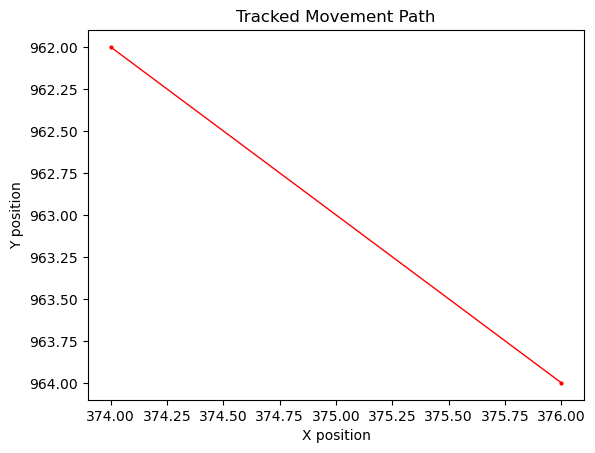

In [2]:
# Downscale factor for lighter processing
scale_factor = 0.5
frame_skip = 5
frame_limit = 10000

# Read first two frames
ret, frame1 = cap.read()
if ret:
    frame1 = cv2.resize(frame1, (0, 0), fx=scale_factor, fy=scale_factor)

ret, frame2 = cap.read()
if ret:
    frame2 = cv2.resize(frame2, (0, 0), fx=scale_factor, fy=scale_factor)

# Track movement positions
movement_positions = []
frame_count = 0

while cap.isOpened() and frame_count < frame_limit:
    if frame_count % frame_skip == 0:
        # Calculate absolute difference between frames
        diff = cv2.absdiff(frame1, frame2)
        
        # Convert diff image to RGB and resize for ViT input
        diff_rgb = cv2.cvtColor(diff, cv2.COLOR_BGR2RGB)
        resized_diff = cv2.resize(diff_rgb, (224, 224))
        
        # Preprocess the image for ViT
        inputs = feature_extractor(images=resized_diff, return_tensors="pt").to(device)
        
        # Detect movement with ViT
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            predicted_class = logits.argmax(-1).item()
        
        # Define movement threshold (use frame differencing here)
        if predicted_class == 0:  # 0 class typically corresponds to 'no movement'
            pass
        else:
            # Find the moving region center
            gray_diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
            _, thresh = cv2.threshold(gray_diff, 30, 255, cv2.THRESH_BINARY)
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            for contour in contours:
                if cv2.contourArea(contour) < 500:
                    continue
                x, y, w, h = cv2.boundingRect(contour)
                center_x = x + w // 2
                center_y = y + h // 2
                movement_positions.append((center_x, center_y))
        
        # Prepare for next frame
        frame1 = frame2
        ret, frame2 = cap.read()
        if ret:
            frame2 = cv2.resize(frame2, (0, 0), fx=scale_factor, fy=scale_factor)
        else:
            break

    frame_count += 1

cap.release()

# Plot the movement path
if movement_positions:
    x_coords, y_coords = zip(*movement_positions)
    plt.plot(x_coords, y_coords, 'ro-', markersize=2, linewidth=1)
    plt.gca().invert_yaxis()
    plt.title("Tracked Movement Path")
    plt.xlabel("X position")
    plt.ylabel("Y position")
    plt.show()
else:
    print("No movement detected in the video.")

In [ ]:
def smooth_path(points, window_size=25):
    smoothed_points = []
    for i in range(len(points)):
        if i < window_size:
            smoothed_points.append(points[i])
        else:
            avg_x = int(np.mean([p[0] for p in points[i - window_size:i]]))
            avg_y = int(np.mean([p[1] for p in points[i - window_size:i]]))
            smoothed_points.append((avg_x, avg_y))
    return smoothed_points

# Apply smoothing
smoothed_movement_positions = smooth_path(movement_positions)

# Plot the smoothed movement path
x_coords, y_coords = zip(*smoothed_movement_positions) if smoothed_movement_positions else ([], [])
plt.plot(x_coords, y_coords, 'bo-', markersize=2, linewidth=1)
plt.gca().invert_yaxis()
plt.title("Smoothed Movement Path")
plt.xlabel("X position")
plt.ylabel("Y position")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

img = mpimg.imread('court.png')

def filter_outliers(points, max_distance=30):
    filtered_points = [points[0]]
    for i in range(1, len(points)):
        dist = np.sqrt((points[i][0] - points[i-1][0])**2 + (points[i][1] - points[i-1][1])**2)
        if dist < max_distance:
            filtered_points.append(points[i])
    return filtered_points

# smoothed_movement_positions = [(10, 20), (15, 25), (35, 40), (50, 55), (70, 75)]

# Apply outlier filtering
filtered_movement_positions = filter_outliers(smoothed_movement_positions)


if filtered_movement_positions:
    x_coords, y_coords = zip(*filtered_movement_positions)
else:
    x_coords, y_coords = [], []

flip_horizontal = True
flip_vertical = True

# Apply flipping transformations
if flip_horizontal:
    x_coords = [-x for x in x_coords]  
if flip_vertical:
    y_coords = [-y for y in y_coords]  

image_height, image_width = img.shape[:2]

x_coords = np.interp(x_coords, (min(x_coords), max(x_coords)), (0, image_width))
y_coords = np.interp(y_coords, (min(y_coords), max(y_coords)), (0, image_height))

x_limits = (200, 3500)
y_limits = (100, 2000)

plt.xlim(x_limits)
plt.ylim(y_limits)

plt.imshow(img, extent=[x_limits[0], x_limits[1], y_limits[0], y_limits[1]])

# Plot the filtered and shifted points over the background image
plt.plot(x_coords, y_coords, 'bo-', markersize=2, linewidth=1)
plt.gca().invert_yaxis()  # Invert y-axis to match the image's coordinate system
plt.title("Filtered Movement Path")
plt.xlabel("X position")
plt.ylabel("Y position")

# Display the plot
plt.show()
print(len(filtered_movement_positions))


In [ ]:
# Calculate the total distance
def calculate_total_distance(points):
    total_distance = 0
    for i in range(1, len(points)):
        dist = np.sqrt((points[i][0] - points[i-1][0])**2 + (points[i][1] - points[i-1][1])**2)
        total_distance += dist
    return total_distance

# Get the total distance of the filtered path
total_distance = calculate_total_distance(filtered_movement_positions)
print(f"Total distance: {total_distance/13}")

print(f"Average Speed: {(total_distance/13)/4}")


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Load the background image of the basketball court
img = mpimg.imread('court.png')

# Outlier filtering function (same as before)
def filter_outliers(points, max_distance=30):
    filtered_points = [points[0]]
    for i in range(1, len(points)):
        dist = np.sqrt((points[i][0] - points[i-1][0])**2 + (points[i][1] - points[i-1][1])**2)
        if dist < max_distance:
            filtered_points.append(points[i])
    return filtered_points

# Example smoothed movement positions (replace with your actual data)

# Apply outlier filtering
filtered_movement_positions = filter_outliers(smoothed_movement_positions)

# Extract x and y coordinates
if filtered_movement_positions:
    x_coords, y_coords = zip(*filtered_movement_positions)
else:
    x_coords, y_coords = [], []

# Flip options
flip_horizontal = True
flip_vertical = True

# Apply flipping transformations if necessary
if flip_horizontal:
    x_coords = [-x for x in x_coords]
if flip_vertical:
    y_coords = [-y for y in y_coords]

# Get image dimensions to scale the path correctly
image_height, image_width = img.shape[:2]

# Normalize movement data based on image dimensions
x_coords = np.interp(x_coords, (min(x_coords), max(x_coords)), (0, image_width))
y_coords = np.interp(y_coords, (min(y_coords), max(y_coords)), (0, image_height))

# Define the x and y axis limits for the plot
x_limits = (200, 3500)
y_limits = (100, 2000)

# Set the xlim and ylim for the plot
plt.xlim(x_limits)
plt.ylim(y_limits)

# Display the basketball court image
plt.imshow(img, extent=[x_limits[0], x_limits[1], y_limits[0], y_limits[1]])

# Create a 2D histogram (heatmap) of the movement positions
heatmap, xedges, yedges = np.histogram2d(x_coords, y_coords, bins=50, range=[[x_limits[0], x_limits[1]], [y_limits[0], y_limits[1]]])

# Display the heatmap using pcolormesh
plt.pcolormesh(xedges, yedges, heatmap.T, cmap='hot', alpha=0.6)

# Plot the filtered movement points on top of the heatmap
plt.plot(x_coords, y_coords, 'bo-', markersize=2, linewidth=1)

# Invert the y-axis to match the image's coordinate system
plt.gca().invert_yaxis()

# Set the title and labels
plt.title("Filtered Movement Path with Heatmap")
plt.xlabel("X position")
plt.ylabel("Y position")

# Display the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Load the background image of the basketball court
img = mpimg.imread('court.png')

# Outlier filtering function (same as before)
def filter_outliers(points, max_distance=30):
    filtered_points = [points[0]]
    for i in range(1, len(points)):
        dist = np.sqrt((points[i][0] - points[i-1][0])**2 + (points[i][1] - points[i-1][1])**2)
        if dist < max_distance:
            filtered_points.append(points[i])
    return filtered_points

# Example smoothed movement positions (replace with your actual data)

# Apply outlier filtering
filtered_movement_positions = filter_outliers(smoothed_movement_positions)

# Extract x and y coordinates
if filtered_movement_positions:
    x_coords, y_coords = zip(*filtered_movement_positions)
else:
    x_coords, y_coords = [], []

# Flip options
flip_horizontal = True
flip_vertical = True

# Apply flipping transformations if necessary
if flip_horizontal:
    x_coords = [-x for x in x_coords]
if flip_vertical:
    y_coords = [-y for y in y_coords]

# Get image dimensions to scale the path correctly
image_height, image_width = img.shape[:2]

# Normalize movement data based on image dimensions
x_coords = np.interp(x_coords, (min(x_coords), max(x_coords)), (0, image_width))
y_coords = np.interp(y_coords, (min(y_coords), max(y_coords)), (0, image_height))

# Define the x and y axis limits for the plot
x_limits = (200, 3500)
y_limits = (100, 2000)

# Set the xlim and ylim for the plot
plt.xlim(x_limits)
plt.ylim(y_limits)

# Display the basketball court image
plt.imshow(img, extent=[x_limits[0], x_limits[1], y_limits[0], y_limits[1]])

# Create a 2D histogram (heatmap) of the movement positions
heatmap, xedges, yedges = np.histogram2d(x_coords, y_coords, bins=10, range=[[x_limits[0], x_limits[1]], [y_limits[0], y_limits[1]]])

# Increase the intensity of the heatmap (by scaling the heatmap values)
heatmap = heatmap * 5  # Adjust this scaling factor as needed

# Display the heatmap using pcolormesh with a higher intensity
plt.pcolormesh(xedges, yedges, heatmap.T, cmap='hot', alpha=.7)  
# Invert the y-axis to match the image's coordinate system
plt.gca().invert_yaxis()

# Set the title and labels
plt.title("Heatmap Over Basketball Court")
plt.xlabel("X position")
plt.ylabel("Y position")

# Display the plot
plt.show()


In [ ]:
def calculate_total_distance_and_time(points):
    total_distance = 0
    total_time = 0
    for i in range(1, len(points)):
        # Calculate distance between points
        dist = np.sqrt((points[i][0] - points[i-1][0])**2 + (points[i][1] - points[i-1][1])**2)
        total_distance += dist
        
        # Calculate time difference
        time_diff = points[i][2] - points[i-1][2]
        total_time += time_diff
    return total_distance, total_time

# Get the total distance and time
total_distance, total_time = calculate_total_distance_and_time(filtered_movement_positions)
average_speed = total_distance / total_time if total_time > 0 else 0
print(f"Total distance: {total_distance}")
print(f"Total time: {total_time}")
print(f"Average speed: {average_speed} units per second")

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from transformers import ViTImageProcessor, ViTForImageClassification

# Load ViT model and image processor
image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
model.eval()

# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def process_video(video_path, sample_rate=30):
    """Process video with reduced sampling rate"""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError("Could not open video file")
    
    # Get video properties
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Total frames: {total_frames}")
    
    # Initialize paths storage
    paths = []
    
    try:
        frame_count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
                
            # Only process every nth frame
            if frame_count % sample_rate == 0:
                # Resize frame to reduce memory usage
                frame = cv2.resize(frame, (640, 480))
                
                # Convert to grayscale for motion detection
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                
                # Apply simple thresholding to find moving objects
                _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
                contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
                # Process largest contour only
                if contours:
                    largest_contour = max(contours, key=cv2.contourArea)
                    if cv2.contourArea(largest_contour) > 100:  # Minimum area threshold
                        x, y, w, h = cv2.boundingRect(largest_contour)
                        center = (x + w//2, y + h//2)
                        paths.append(center)
                        
                        # Draw rectangle and center point
                        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                        cv2.circle(frame, center, 3, (0, 0, 255), -1)
                
                # Display frame
                cv2.imshow('Tracking', frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                
                # Clear some memory
                if device.type == 'cuda':
                    torch.cuda.empty_cache()
            
            frame_count += 1
            if frame_count % 100 == 0:
                print(f"Processed {frame_count} frames")
    
    except Exception as e:
        print(f"Error during processing: {e}")
    
    finally:
        cap.release()
        cv2.destroyAllWindows()
        return paths

def plot_motion_path(paths):
    """Plot the motion path"""
    if not paths:
        print("No paths to plot")
        return
        
    paths = np.array(paths)
    plt.figure(figsize=(10, 8))
    plt.plot(paths[:, 0], paths[:, 1], 'b-', label='Motion Path')
    plt.scatter(paths[0, 0], paths[0, 1], color='green', label='Start', s=100)
    plt.scatter(paths[-1, 0], paths[-1, 1], color='red', label='End', s=100)
    plt.gca().invert_yaxis()
    plt.title('Object Motion Path')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main execution
if __name__ == "__main__":
    video_path = "soccer.mp4"  # Replace with your video path
    
    print("Starting video processing...")
    paths = process_video(video_path, sample_rate=30)  # Process every 30th frame
    
    print("Plotting motion path...")
    plot_motion_path(paths)